## Initialization

In [18]:
import os, sys
import torch
import transformers
from torch.utils.data import DataLoader, SequentialSampler
import argparse
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import sys
sys.path.append("/home/divy/FiD")

In [3]:
import src
from src.data import load_data
from src.evaluation import ems
import src.model

## Load data

Try out NQ with NQ pretrained checkpoint

In [4]:
eval_examples = load_data(
                            "/mnt/disks/external_mounted_disk/datasets/NQ/NQ/dev.json",
                            global_rank=0,
                            world_size=1,
                            )

In [5]:
n_passages = 10
eval_dataset = src.data.Dataset(eval_examples, n_passages)

sampler = SequentialSampler(eval_dataset)
tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')
collator = src.data.Collator(200, tokenizer, answer_maxlength=-1)

len(eval_dataset)

/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


8757

In [6]:
dataloader = DataLoader(eval_dataset,
        sampler=sampler,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

/opt/conda/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [7]:
for i, b in enumerate(dataloader):
    print(b)
    if i >= 0:
        break
    

(tensor([0]), tensor([[16121,  8688,     1]]), tensor([[True, True, True]]), tensor([[[822,  10, 113,  ...,   0,   0,   0],
         [822,  10, 113,  ...,   0,   0,   0],
         [822,  10, 113,  ...,   0,   0,   0],
         ...,
         [822,  10, 113,  ...,   0,   0,   0],
         [822,  10, 113,  ...,   0,   0,   0],
         [822,  10, 113,  ...,   0,   0,   0]]]), tensor([[[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]]]))


## Load model

In [7]:
model_name = 't5-base'
model_class = src.model.FiDT5

In [8]:
load_path = "/home/divy/FiD/model_ckpts/nq_reader_base"
model = model_class.from_pretrained(load_path)

In [9]:
model = model.to('cuda')

### load an example input, generated output and ground truth output

In [10]:
for i, batch in enumerate(dataloader):
    (idx, labels, _, context_ids, context_mask) = batch
    
    if i == 0:
        print(idx)
        print(context_ids.shape)
        #print(context_ids[0][0])
        for j in range(context_ids.shape[1]):

            print("====")
            print(j)
            context = tokenizer.decode(context_ids[0][j])
            print(context)
        
        print("")
        print("")
        print("generated answer:")
        generated_output = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                max_length=50
            ).cpu()

        human_readable_generated_output = tokenizer.decode(generated_output[0])
        print(human_readable_generated_output)
        
        print("")
        print("")
        print("ground truth answer:")

        print(tokenizer.decode(labels[0]))

        forward = model(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                decoder_input_ids=labels.cuda(),
                output_attentions=True,
                output_unnormalized_attentions=False
            )           
    
        break

tensor([0])
torch.Size([1, 10, 196])
====
0
question: who sings does he love me with reba title: Does He Love You context: Does He Love You "Does He Love You" is a song written by Sandy Knox and Billy Stritch, and recorded as a duet by American country music artists Reba McEntire and Linda Davis. It was released in August 1993 as the first single from Reba's album "Greatest Hits Volume Two". It is one of country music's several songs about a love triangle. "Does He Love You" was written in 1982 by Billy Stritch. He recorded it with a trio in which he performed at the time, because he wanted a song that could be sung by the other two members</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
====
1
question: who sings does he love me with reba title: Linda Davis context: Linda Davis Linda Kaye Davis (born November 26, 1962) is

/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/modeling_utils.py:656: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


<pad> Linda Kaye Davis</s>


ground truth answer:
Linda Davis</s>


## Extract cross attention matrices

In [97]:
len(forward.cross_attentions)

12

In [98]:
stacked_forward_attentions = torch.cat(forward.cross_attentions, dim=0)
stacked_forward_attentions.shape

torch.Size([12, 12, 3, 880])

In [99]:
torch.mean(stacked_forward_attentions[:, :, 0, :])

tensor(-80681824., device='cuda:0', grad_fn=<MeanBackward0>)

In [34]:
forward.cross_attentions[0].shape

torch.Size([1, 12, 3, 322])

In [35]:
torch.mean(forward.cross_attentions[0][:, :, 0, :])

tensor(-27950314., device='cuda:0', grad_fn=<MeanBackward0>)

In [36]:
forward.cross_attentions[0].shape

torch.Size([1, 12, 3, 322])

In [37]:
torch.sum(forward.cross_attentions[3], dim=-1).shape

torch.Size([1, 12, 3])

In [38]:
torch.sum(forward.cross_attentions[0], dim=-1)

tensor([[[-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09]]], device='cuda:0',
       grad_fn=<SumBackward1>)

In [30]:
forward.cross_attentions[0][0][0][1]

tensor([ 1.9729e+00,  1.3851e+00, -2.1832e+00, -1.1376e+00, -1.2776e+00,
        -3.4125e+00, -5.3054e+00, -4.8791e+00, -3.2870e+00, -4.4425e+00,
        -1.8687e+00, -2.5599e+00, -2.6223e+00, -4.1923e+00, -1.3342e+00,
        -5.2764e-01,  5.1298e-01, -4.1823e+00, -4.5534e+00, -3.5556e+00,
        -4.6796e+00, -8.2563e-01,  9.5785e-01, -3.3178e+00, -3.6698e+00,
        -3.0187e+00, -4.7601e+00, -4.2497e+00, -2.8946e+00, -5.3650e+00,
        -3.4801e+00, -4.4688e+00, -3.2278e+00, -4.8753e+00, -3.7288e+00,
        -1.9606e+00,  1.3321e+00, -3.6053e+00, -1.8468e+00, -4.1075e+00,
        -2.9598e+00, -2.5535e+00, -2.2707e+00, -3.5604e+00, -3.8036e+00,
        -2.4402e+00, -4.0344e+00, -2.8101e+00, -5.1451e+00, -1.9998e+00,
        -1.9949e+00,  1.3623e+00, -9.9303e-01,  8.5180e-01, -2.4537e-01,
        -1.4495e+00, -1.2180e+00,  5.8565e-01,  6.4136e-01,  1.1378e+00,
        -8.3264e-01, -1.4387e+00, -1.5302e+00, -1.3770e+00, -8.3234e-01,
        -5.2860e-01,  2.6433e+00,  3.8919e-01, -9.3

In [248]:
torch.sum(forward.cross_attentions[0], dim=-1)

tensor([[[-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.400

## compute g_{q,p}

In [182]:
stacked_forward_attentions = torch.cat(forward.cross_attentions, dim=0)

In [183]:
stacked_forward_attentions.shape

torch.Size([12, 12, 3, 1960])

In [184]:
context_mask.shape

torch.Size([1, 10, 196])

In [185]:
msk = torch.reshape(context_mask, (1, context_mask.shape[1]*context_mask.shape[2])).cuda()
msk.shape

torch.Size([1, 1960])

In [186]:
masked_stacked_forward_attentions = stacked_forward_attentions.masked_fill(msk == False, 0.0)

In [187]:
masked_stacked_forward_attentions.shape

torch.Size([12, 12, 3, 1960])

In [188]:
for i in range(context_mask.shape[1]):
    print(i)
    sliced_masked_stacked_forward_attentions = masked_stacked_forward_attentions[:, :, :, (i*context_mask.shape[2]):((i + 1)*context_mask.shape[2])]
    print(sliced_masked_stacked_forward_attentions.shape)
    g_qp = torch.mean(sliced_masked_stacked_forward_attentions[:, :, 0, :])
    print(g_qp)
    print("============")
    

0
torch.Size([12, 12, 3, 196])
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
1
torch.Size([12, 12, 3, 196])
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
2
torch.Size([12, 12, 3, 196])
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
3
torch.Size([12, 12, 3, 196])
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
4
torch.Size([12, 12, 3, 196])
tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
5
torch.Size([12, 12, 3, 196])
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
6
torch.Size([12, 12, 3, 196])
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
7
torch.Size([12, 12, 3, 196])
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
8
torch.Size([12, 12, 3, 196])
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
9
torch.Size([12, 12, 3, 196])
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


In [189]:
g_qp = model.obtain_gqp(
    input_ids=context_ids.cuda(),
    attention_mask=context_mask.cuda(),
    decoder_input_ids=labels.cuda(),
    output_attentions=True,
    output_unnormalized_attentions=False
)

g_qp = [el.detach() for el in g_qp]

g_qp

[tensor(0.0006),
 tensor(0.0006),
 tensor(0.0005),
 tensor(0.0005),
 tensor(0.0007),
 tensor(0.0004),
 tensor(0.0005),
 tensor(0.0004),
 tensor(0.0004),
 tensor(0.0006)]

In [161]:
averaged_attention_matrix = torch.mean(masked_stacked_forward_attentions, dim = (0, 1)).detach().cpu().numpy()


### Visualise layer-head averaged cross-attention matrix

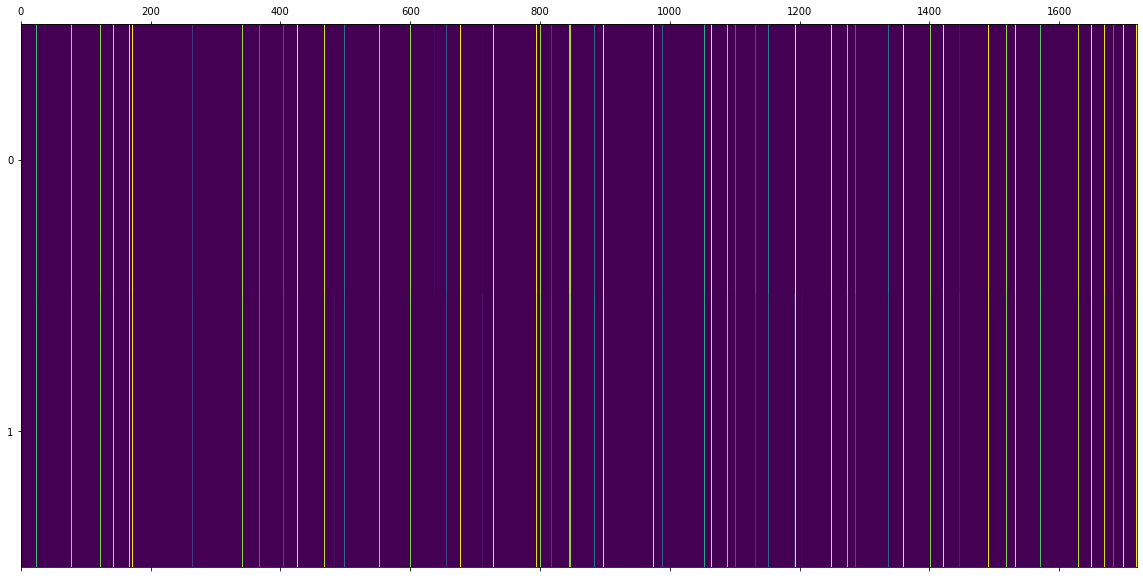

In [162]:
fig = plt.figure(figsize=(20, 10), facecolor="white")
ax = fig.add_subplot()
#ax.imshow(averaged_attention_matrix[:, :], cmap='hot', interpolation='nearest')
ax.matshow(averaged_attention_matrix[:2, :], aspect='auto', vmin=0)

In [86]:
averaged_attention_matrix.shape

(2, 1980)

## Obtaining the generative output score

In [21]:
len(dataloader)

8757

### Figure out prevalence of very confident, correct vs incorrect answers

In [100]:
# only one context vector

exact_match_log_probabilities = []
incorrect_log_probabilities = []

for i, batch in tqdm(enumerate(dataloader)):
    
    (idx, _, _, context_ids, context_mask) = batch
    sequences = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                max_length=10,
                return_dict_in_generate=True,
                output_scores=True
            ).sequences

    

    
    for k, o in enumerate(sequences):
        ans = tokenizer.decode(o, skip_special_tokens=True)
        gold = eval_dataset.get_example(idx[k])['answers']
        score = ems(ans, gold)
        #print(score)
        # total += 1
        # exactmatch.append(score)
#         print("model generated output:")
#         print(ans)

#         print("")
#         print("ground truth:")
#         print(gold) 

    # print("extracting negative log probability ...")
    log_probability = model.obtain_log_generated_probability(
        input_ids=context_ids.cuda(),
        attention_mask=context_mask.cuda(),
        max_length=10

    )
    
    if score == True:
        exact_match_log_probabilities.append(log_probability.cpu().numpy())
    
    else:
        incorrect_log_probabilities.append(log_probability.cpu().numpy())

    if i > 3000:
        break


3001it [14:33,  3.44it/s]


In [101]:
print("exact match distribution")
print(len(exact_match_log_probabilities))
print(np.mean(exact_match_log_probabilities))
print(np.std(exact_match_log_probabilities))

exact match distribution
1369
0.2694918
0.34998545


In [102]:
print("incorrect match distribution")
print(len(incorrect_log_probabilities))
print(np.mean(incorrect_log_probabilities))
print(np.std(incorrect_log_probabilities))

incorrect match distribution
1633
0.7074354
0.7308814


Text(0, 0.5, 'log_sum_prob')

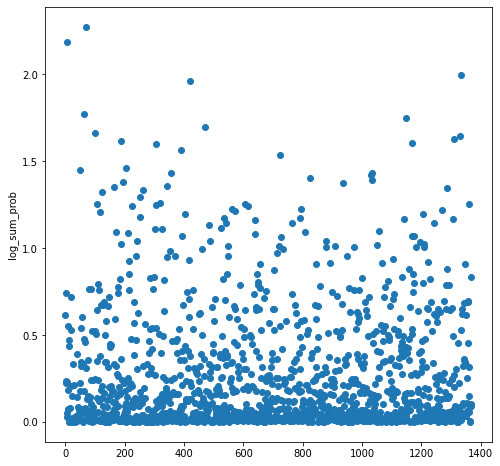

In [107]:
fig = plt.figure(figsize=(8,8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(list(range(len(exact_match_log_probabilities))), exact_match_log_probabilities)
ax.set_ylabel("log_sum_prob")

Text(0, 0.5, 'log_sum_prob')

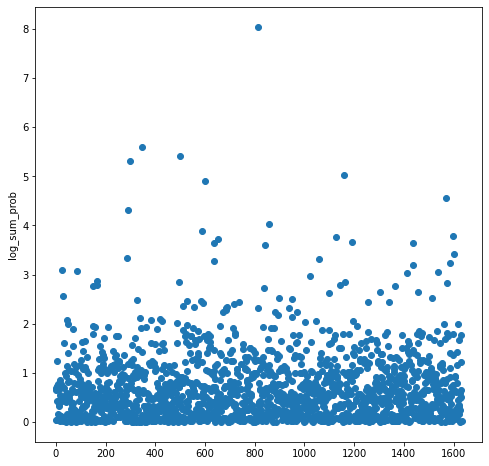

In [108]:
fig = plt.figure(figsize=(8,8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(list(range(len(incorrect_log_probabilities))), incorrect_log_probabilities)
ax.set_ylabel("log_sum_prob")

In [118]:
confidence_threshold = 0.02

true_positive = len([el for el in exact_match_log_probabilities if el < confidence_threshold])
false_positive = len([el for el in incorrect_log_probabilities if el < confidence_threshold])

precision = true_positive / (true_positive + false_positive)
precision

0.813953488372093

### Obtain example generated vs ground truth outputs

In [47]:
# only one context vector
for i, batch in enumerate(dataloader):
    
    if i == 7:
        print(f"training example: {i}")
        (idx, _, _, context_ids, context_mask) = batch
        sequences = model.generate(
                    input_ids=context_ids.cuda(),
                    attention_mask=context_mask.cuda(),
                    max_length=10,
                    return_dict_in_generate=True,
                    output_scores=True
                ).sequences

        print(sequences)
        for k, o in enumerate(sequences):
            ans = tokenizer.decode(o, skip_special_tokens=True)
            gold = eval_dataset.get_example(idx[k])['answers']
            score = ems(ans, gold)
            #print(score)
            # total += 1
            # exactmatch.append(score)
            print("model generated output:")
            print(ans)

            print("")
            print("ground truth:")
            print(gold) 
        
        print("extracting negative log probability ...")
        log_probability = model.obtain_log_generated_probability(
            input_ids=context_ids.cuda(),
            attention_mask=context_mask.cuda(),
            max_length=10
            
        )
        
        print(score)
        
        print(log_probability)
        
        break


training example: 7
tensor([[   0, 4407,    1]], device='cuda:0')
model generated output:
2002

ground truth:
['2002']
extracting negative log probability ...
True
tensor(0.6189, device='cuda:0')


In [92]:
softmax = torch.nn.Softmax(dim=1)
total_log_prob = 0
for i in range(len(outputs.scores)):
    print(torch.log(torch.max(softmax(outputs.scores[i]))))
    total_log_prob -= torch.log(torch.max(softmax(outputs.scores[i])))

total_log_prob

tensor(-0.9990, device='cuda:0')
tensor(-0.0031, device='cuda:0')
tensor(-2.1935e-05, device='cuda:0')
tensor(-7.8800e-05, device='cuda:0')
tensor(-0.0035, device='cuda:0')


tensor(1.0057, device='cuda:0')

## Comparing tokenizers

In [31]:
bert_tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
t5_tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')

In [32]:
input_sequence = "Welcome to the HuggingFace Library"

In [35]:
bert_tokenized = bert_tokenizer(input_sequence, return_tensors='pt')
t5_tokenized = t5_tokenizer(input_sequence, return_tensors='pt')

print(bert_tokenized.input_ids)
print("===")
print(t5_tokenized.input_ids)

tensor([[  101,  6160,  2000,  1996, 17662, 12172,  3075,   102]])
===
tensor([[ 5242,    12,     8, 11560,  3896,   371,  3302,  5355,     1]])


In [40]:
print(bert_tokenizer.decode(bert_tokenized.input_ids[0]))
print("===")
print(t5_tokenizer.decode(t5_tokenized.input_ids[0]))

[CLS] welcome to the huggingface library [SEP]
===
Welcome to the HuggingFace Library</s>


In [46]:
bert_tokenizer.convert_ids_to_tokens(bert_tokenized.input_ids[0])

['[CLS]', 'welcome', 'to', 'the', 'hugging', '##face', 'library', '[SEP]']

In [45]:
t5_tokenizer.convert_ids_to_tokens(t5_tokenized.input_ids[0])

['▁Welcome', '▁to', '▁the', '▁Hug', 'ging', 'F', 'ace', '▁Library', '</s>']

In [52]:
z = torch.randn((2, 4))

In [54]:
msk = torch.tensor([[True, False, True], [False, True, False]])
msk2 = torch.tensor([[True, False, True, True]])

In [43]:
z

tensor([[-1.1771,  0.8998, -0.6725],
        [-1.0138,  1.7796, -0.3884]])

In [55]:
z.masked_fill(msk2 == 0, 0.0)

tensor([[ 1.3247,  0.0000, -0.0618, -0.7110],
        [-0.9271,  0.0000,  0.5299,  0.6540]])

In [242]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained('t5-small')


/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [243]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [244]:
input_ids = tokenizer.encode("summarize: Hello, my dog is cute", return_tensors="pt")  # Batch size 1

In [252]:
sequence = model.generate(input_ids, return_dict_in_generate=True, output_scores=True).sequences

In [259]:
sequence

tensor([[   0,   82, 1782,   19, 5295,   11, 5295,    5,    1]])

In [255]:
scores = model.generate(input_ids, return_dict_in_generate=True, output_scores=True).scores

In [262]:
torch.argmax(scores[1])

tensor(1782)

In [263]:
torch.max(scores[1])

tensor(-2.6708)